# Hotkeys  
- `A`, `B` front and back
- `ESC`, `ENTER` writing or commands
- `M`, `Y` md and code 


# Start

In [1]:
#r "nuget:Microsoft.Data.Analysis"
#r "nuget:ScottPlot"

using System;
using System.Reflection;

using Microsoft.DotNet.Interactive.Formatting;

using Microsoft.Data.Analysis;

using Newtonsoft.Json;

bool DEBUG = true;

Installed Packages Microsoft.Data.Analysis, 0.21.1 ScottPlot, 5.0.36

Loading extensions from `C:\Users\Joni1\.nuget\packages\microsoft.data.analysis\0.21.1\interactive-extensions\dotnet\Microsoft.Data.Analysis.Interactive.dll`

Loading extensions from `C:\Users\Joni1\.nuget\packages\skiasharp\2.88.8\interactive-extensions\dotnet\SkiaSharp.DotNet.Interactive.dll`

In [2]:
Formatter.Register(typeof(ScottPlot.Plot), (p, w) => w.Write(((ScottPlot.Plot)p).GetImageHtml(400, 300)), HtmlFormatter.MimeType);

class PlotBuilder {
    ScottPlot.Plot plot;

    public PlotBuilder (string title = "") {
        plot = new ();
        plot.Axes.Title.Label.Text = title;
    }

    public PlotBuilder Add<T1, T2> (List<T1> x, List<T2> y, string legend = default) {
        plot.Add.Scatter(x, y).LegendText = legend ?? "";
        return this;
    }
    public PlotBuilder Add<T> (List<T> y, string legend = default) => Add(Enumerable.Range(0, y.Count).ToList(), y, legend);
    public PlotBuilder Add<T> (List<(T,T)> y, (string, string) legend = default) =>
         Add(y.Select(y => y.Item1).ToList(), legend.Item1)
        .Add(y.Select(y => y.Item2).ToList(), legend.Item2);
    public PlotBuilder Add<T> (List<(T,T,T)> y, (string, string, string) legend = default) => 
         Add(y.Select(y => y.Item1).ToList(), legend.Item1)
        .Add(y.Select(y => y.Item2).ToList(), legend.Item2)
        .Add(y.Select(y => y.Item3).ToList(), legend.Item3);

    public PlotBuilder LimitY(double y0, double y1) {
        plot.Axes.SetLimitsY(y0, y1);
        return this;
    } 
    public PlotBuilder Limit(double x0, double x1, double y0, double y1) {
        plot.Axes.SetLimits(x0, x1, y0, y1);
        return this;
    }
    public PlotBuilder LimitH(double h) => LimitY(0, h); 

    public ScottPlot.Plot Build ()  {  
        plot.Axes.SetLimits(0, 1000);
        return plot; 
    }
}

In [3]:
static string DumpS(this object value) => value is not string ? JsonConvert.SerializeObject(value, Formatting.None) : value as string;

static T[] DumpMulti<T> (this T[] values) {
    values.ToList().ForEach(item => item.Dump());
    return values;  
} 
static IEnumerable<T> DumpMulti<T> (this IEnumerable<T> values) {
    values.ToList().ForEach(item => item.Dump());
    return values;
} 
static T Dump<T>(this T value) => DumpOneLine(value);

static T DumpOneLine<T> (this T value) {
    Console.WriteLine(value.DumpS());
    return value;
}
static void Log(this object item) => Console.WriteLine(item);

In [4]:
static BindingFlags flags = BindingFlags.Public | BindingFlags.Instance;

static DataFrame CreateDataFrame (IEnumerable<object> values) {
    Type type = values.First().GetType();

    if (type.IsPrimitive)
        return DataFrame.LoadFrom(values.Select(i => new List<object>() { i }), new List<(string, Type)>() { ("", type)});

    FieldInfo[] fields = type.GetFields(flags);
    PropertyInfo[] properties = type.GetProperties(flags);

    IEnumerable<DataFrame> dataFields = fields.Select(field => CreateDataFrame(values.Select(field.GetValue)).AddPrefix($"{field.Name} ", inPlace: true));
    IEnumerable<DataFrame> dataProperties = properties.Select(property => CreateDataFrame(values.Select(property.GetValue)).AddPrefix($"{property.Name} ", inPlace: true));
    IEnumerable<DataFrameColumn> columns = new [] { dataFields, dataProperties }.SelectMany(frames => frames).SelectMany(frame => frame.Columns);
    return new DataFrame(columns);
}
static DataFrame CreateDataFrame<T> (IEnumerable<T> values) => CreateDataFrame(values.Select(i => (object)i));

static DataFrame ToDataFrame<T>(this IEnumerable<T> objects, params (int index, string name)[] names) {
    FieldInfo[] fields = typeof(T).GetFields();

    string[] prefixes = new string[fields.Length];
    foreach (var t in names) 
        prefixes[t.index] = t.name;

    IEnumerable<DataFrame> dataFrames = fields.Select((field, i) => CreateDataFrame(objects.Select(obj => field.GetValue(obj))).AddPrefix(prefixes[i], inPlace: true));
    IEnumerable<DataFrameColumn> columns = dataFrames.SelectMany(df => df.Columns);

    return new DataFrame(columns);
} 
static DataFrame ToDataFrame<T>(this IEnumerable<T> objects, string prefix = "")    => CreateDataFrame(objects.ToList()).AddPrefix(prefix, inPlace: true); 
static DataFrame ToDataFrame<T>(this List<T> objects, string prefix = "")           => CreateDataFrame(objects).AddPrefix(prefix, inPlace: true); 
static DataFrame Concat(this DataFrame df, DataFrame added, string prefix = "" )    => new DataFrame(df.Columns.Concat(added.Clone().AddPrefix(prefix).Columns));

In [5]:
Random random = new Random(29);

float NextGauss (float mean, float stdDev) {
    float u1 = 1.0f - random.NextSingle();
    float u2 = 1.0f - random.NextSingle();
    float randStdNormal = (float)Math.Sqrt(-2.0f * Math.Log(u1)) * (float)Math.Sin(2.0f * Math.PI * u2); 
    float randNormal = mean + stdDev * randStdNormal; 
    return randNormal;
}
float NextGauss (float mu, float sigma, float min, float max) {
    float x;
    do
    {
        x = NextGauss(mu, sigma);
    } while (x < min || x > max);

    return x;
}

# Simulation

In [6]:
public partial struct Market
{
    public ulong Food, Oxygen, Minerals, Water;
}

public partial struct MarketF
{
    public float Food, Oxygen, Minerals, Water;
}

public struct Population
{
    public ulong Farmers, Laborers, Engineers;
    public ulong Children;
    public ulong Total => Farmers + Laborers + Engineers + Children;
    //public float FarmersNeed, LaborersNeed, EngineersNeed;
}

public struct Points 
{
    public int Value;
}

In [7]:
static Market sub(Market a, Market b) => new Market
    {
        Food     = a.Food     - b.Food,
        Oxygen   = a.Oxygen   - b.Oxygen,
        Minerals = a.Minerals - b.Minerals,
        Water    = a.Water    - b.Water
    };
static MarketF divF(Market a, Market b) => new MarketF
    {
        Food     = (float) a.Food     / b.Food,
        Oxygen   = (float) a.Oxygen   / b.Oxygen,
        Minerals = (float) a.Minerals / b.Minerals,
        Water    = (float) a.Water    / b.Water
    };
static Market min (Market a, Market b) => new Market
    {
        Food     = Math.Min(a.Food,     b.Food),
        Oxygen   = Math.Min(a.Oxygen,   b.Oxygen),
        Minerals = Math.Min(a.Minerals, b.Minerals),
        Water    = Math.Min(a.Water,    b.Water)
    };

In [8]:
void Build(in Population population, out Market market)
{
    market.Food = population.Farmers* 5;
    market.Minerals = population.Laborers;
    market.Oxygen = population.Engineers * 100;
    market.Water = population.Engineers * 20;
}

In [9]:
void Births (float deathRate, ref Population population) {
    float decrease = Math.Clamp(1 - deathRate, 0.8f, 1);
    float increase = 0.02f;//Math.Clamp(NextGauss(0.0002f, 0.0001f), 0, 0.01f);

    population.Children = (ulong) (population.Total * increase);

    population.Farmers   = (ulong)(population.Farmers   * decrease);
    population.Laborers  = (ulong)(population.Laborers  * decrease);
    population.Engineers = (ulong)(population.Engineers * decrease);
} 

In [41]:
void Promote (in MarketF ratios, ref Population population) {
    // children
    if (ratios.Oxygen < 1 || ratios.Water < 1)
        population.Engineers += population.Children;
    else if (ratios.Food < 1)
        population.Farmers += population.Children;
    else
        population.Laborers += population.Children;
}

In [42]:
void Consume(in Market market, ref Population population, out MarketF ratio, out Market surplus)
{
    ulong pops = population.Total;
    
    Market need = new();
    need.Oxygen = pops * 2;
    need.Food   = pops;
    need.Water  = pops;

    Market bought = min(market, need);

    surplus = sub(market, bought);

    ratio = divF(bought, need);
}


In [43]:
struct SimulationState {
    public Market Market;
    public Market Surplus;
    public MarketF Ratio;
    public Population Population;
}
SimulationState state = new () { Population = new Population { Engineers = 10, Farmers = 10, Laborers = 1000 }};

void SimulateStep (ref SimulationState state) {
    Build(in state.Population, out state.Market);
    Consume(in state.Market, ref state.Population, out state.Ratio, out state.Surplus);
    Promote(in state.Ratio, ref state.Population);
    Births(1 - state.Ratio.Oxygen, ref state.Population);
}


List<SimulationState> steps = new() { state };

for (int i = 0; i < 1000; i++) {
    SimulateStep(ref state);
    steps.Add(state);
}


List<int> declines = Enumerable.Range(0, steps.Count - 1).Where((i) => steps[i].Population.Total > steps[i + 1].Population.Total).ToList();
List<Population> populations = steps.Select(s => s.Population).ToList();

new object[] {$"Simulation Completed with {declines.Count} declines", steps.Last().Population, steps.Last().Market }

index type value 0 System.String Simulation Completed with 31 declines 1 Submission#8+Population Submission#8+Population Total 1426398030 Farmers 283006592 Laborers 910945408 Engineers 203929472 Children 28516558 2 Submission#8+Market Submission#8+Market Food 1415032960 Oxygen 3213078016 Minerals 882998976 Water 4078589440


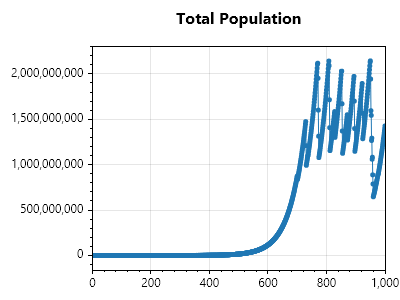

In [44]:
new PlotBuilder("Total Population").Add(populations.Select(pop => pop.Total).ToList()).Build()


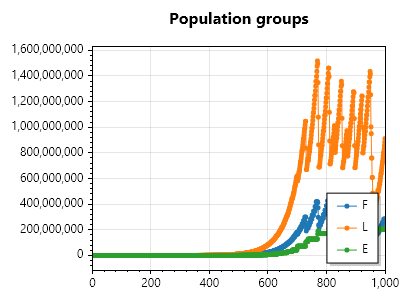

In [45]:
new PlotBuilder("Population groups").Add(populations.Select(pop => (pop.Farmers, pop.Laborers, pop.Engineers)).ToList(), ("F", "L", "E")).Build()


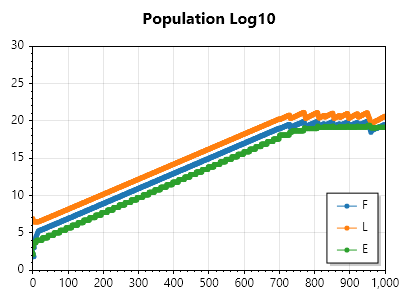

In [46]:
new PlotBuilder("Population Log10").Add(populations.Select(pop => (Math.Log(pop.Farmers), Math.Log(pop.Laborers), Math.Log(pop.Engineers))).ToList(), ("F", "L", "E")).LimitH(30).Build()

In [47]:
steps.ToDataFrame()

index,Market Food,Market Oxygen,Market Minerals,Market Water,Surplus Food,Surplus Oxygen,Surplus Minerals,Surplus Water,Ratio Food,Ratio Oxygen,Ratio Minerals,Ratio Water,Population Farmers,Population Laborers,Population Engineers,Population Children,Population Total
0,0,0,0,0,0,0,0,0,0,0,0,0,10,1000,10,0,1020
1,50,1000,1000,200,0,0,1000,0,0.04901961,0.49019608,NaN,0.19607843,8,800,8,20,836
2,40,800,800,160,0,0,800,0,0.04784689,0.4784689,NaN,0.19138756,6,640,22,17,685
3,30,2200,640,440,0,830,640,0,0.04379562,1,NaN,0.6423358,6,640,39,14,699
4,30,3900,640,780,0,2502,640,81,0.042918455,1,NaN,1,20,640,39,14,713
5,100,3900,640,780,0,2474,640,67,0.14025246,1,NaN,1,34,640,39,14,727
6,170,3900,640,780,0,2446,640,53,0.2338377,1,NaN,1,48,640,39,14,741
7,240,3900,640,780,0,2418,640,39,0.32388663,1,NaN,1,62,640,39,15,756
8,310,3900,640,780,0,2388,640,24,0.4100529,1,NaN,1,77,640,39,15,771
9,385,3900,640,780,0,2358,640,9,0.4993515,1,NaN,1,92,640,39,15,786
